### Project Goal:

PREDICT percent change in stock price after next earnings event for all company

One record per earning event date per company.


## Packages Imports

In [1]:
!pip install pandas_market_calendars

In [72]:
import pandas as pd
import pandas_market_calendars as mcal
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## Loading Data

### Tickers of concern

In [3]:
tickers_df = pd.read_csv("/users/brigitteasullivan/Documents/0. Data Science/Notebooks/Riipen Project/eps-stock-market-ml-project/data/all_tickers-with-options.csv", 
                         header = 0, names = ['Ticker'])
tickers_df

,Ticker
0,\t\t1INVH
1,\t\t1LNCO
2,\t\t1LUV
3,\t\t2LW
4,\t\t9AC
...,...
12829,\t\tZZ
12830,\t\tZZK
12831,\t\tZZV
12832,\t\tZZZ


In [4]:
#trim tab
tickers_df["Ticker"] = tickers_df['Ticker'].str.strip()
tickers_df

,Ticker
0,1INVH
1,1LNCO
2,1LUV
3,2LW
4,9AC
...,...
12829,ZZ
12830,ZZK
12831,ZZV
12832,ZZZ


### Earnings dates

If "WHEN" is premarket - earnings date to watch is same day 
if when is post market - earnings date to watch is next trading date. 

From documentation: https://www.earningscalendar.net/documentation

*   `date` ISO date of this earnings event.
*   `ticker` Ticker as traded on the exchange.
*   `url` URL to the press release that confirmed this event.
*   `title` Title of the press release that confirmed this event.
*   `security\_name` Name of the security trading under this symbol/ticker.
*   `exchange` The exchange where the security is trading. One of AMEX, NASDAQ, NYSE.
*   `when` When are earnings slated to be released that day. Returned only if known, otherwise the string "null".
*   `pub\_date` Publication date of the press release that confirmed this event



In [5]:
earnings_df = pd.read_csv('/users/brigitteasullivan/Documents/0. Data Science/Notebooks/Riipen Project/eps-stock-market-ml-project/data/confirmed_earnings.csv')
earnings_df

,date,exchange,symbol,when,title,url,pub_date,security_name
0,2023-01-03,NASDAQ,LEDS,premarket,SemiLEDs to Announce Fiscal First Quarter 2023...,https://www.businesswire.com/news/home/2022122...,2022-12-27T11:05:00,SemiLEDS Corporation - Common Stock
1,2023-01-03,NASDAQ,SGH,postmarket,SGH Announces First Quarter Fiscal 2023 Financ...,https://www.businesswire.com/news/home/2022121...,2022-12-13T21:05:00,"SMART Global Holdings, Inc. - Ordinary Shares"
2,2023-01-04,NASDAQ,RGP,postmarket,"Resources Connection, Inc. to Announce Fiscal ...",https://www.businesswire.com/news/home/2022122...,2022-12-21T21:05:00,"Resources Connection, Inc. - Common Stock"
3,2023-01-04,NASDAQ,SLP,postmarket,Simulations Plus Sets Date for First Quarter F...,https://www.businesswire.com/news/home/2022121...,2022-12-19T21:06:00,"Simulations Plus, Inc. - Common Stock"
4,2023-01-05,NYSE,CAG,NaN,CONAGRA BRANDS ANNOUNCES DETAILS OF FISCAL 202...,https://www.prnewswire.com/news-releases/conag...,2022-12-05T07:30:00,"ConAgra Brands, Inc. Common Stock"
...,...,...,...,...,...,...,...,...
9471,2023-12-21,NASDAQ,LMNR,postmarket,Limoneira to Announce Fourth Quarter and Full ...,https://www.businesswire.com/news/home/2023120...,2023-12-07T13:30:00,Limoneira Co - Common Stock
9472,2023-12-21,NYSE,NKE,NaN,"NIKE, Inc. Announces Second Quarter Fiscal 202...",https://www.businesswire.com/news/home/2023112...,2023-11-21T21:15:00,"Nike, Inc. Common Stock"
9473,2023-12-21,NASDAQ,PAYX,premarket,"Paychex, Inc. Schedules Second Quarter Fiscal ...",https://www.businesswire.com/news/home/2023120...,2023-12-08T19:00:00,"Paychex, Inc. - Common Stock"
9474,2023-12-21,NYSE,WS,postmarket,Worthington Steel to Webcast Discussion of Sec...,https://www.businesswire.com/news/home/2023120...,2023-12-04T21:10:00,"Worthington Steel, Inc. Common Shares"


### Straddles

In [61]:
straddles_df = pd.read_csv('EarningsStraddles_RecentEarnings_Results_20240211_210820 copy.csv')
straddles_df

,Symbol,Name,Current Price,% Change,Avg Stock Volume,Avg Option Volume,Date,Implied Move,Actual Move,Straddle Return,Avg Straddle Return,Max Return,Min Return,InWatchlist,EtfHoldingsList,MarketCap
0,EDSA,Edesa Biotech - Common Shares,4.83,0.0343,80026,NaN,2/9/2024,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1.531485e+07
1,ASYS,Amtech Systems,3.44,-0.1527,93839,143.0,2/9/2024,0.1210,0.0523,NaN,0.7910,0.9241,0.7153,0,NaN,4.881697e+07
2,FTS,Fortis Common Shares,39.06,0.0031,797151,150.0,2/9/2024,0.0347,0.0031,-0.0459,0.1247,0.8084,-0.4825,0,NaN,1.908081e+10
3,CTLT,Catalent,56.71,0.0028,2497920,2186.0,2/9/2024,0.0397,0.0028,-0.4520,0.1496,0.5174,-0.3961,0,SPY - XLV,1.024417e+10
4,NWL,Newell Brands,6.85,-0.1893,4255129,1956.0,2/9/2024,0.0976,-0.1893,0.9235,-0.1984,-0.0296,-0.4570,0,NaN,2.837270e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4480,BYRN,Byrna Technologies,9.84,0.1069,85590,60.0,10/12/2023,0.1409,0.0221,-0.0941,1.5457,2.7886,-0.6517,0,NaN,2.165000e+08
4481,DPZ,Domino's Pizza,425.09,-0.0035,585561,2915.0,10/12/2023,0.0558,-0.0110,-0.6825,0.1485,0.6398,-0.5731,0,SPY - XLY,1.482756e+10
4482,RMCF,Rocky Mountain Chocolate Factory,4.05,0.0050,16550,NaN,10/12/2023,NaN,-0.0545,NaN,NaN,NaN,NaN,0,NaN,2.557680e+07
4483,DOGZ,Dogness (Intl),3.53,0.0665,93563,11.0,10/11/2023,0.1009,0.0111,NaN,0.3535,1.0157,-0.0596,0,NaN,7.370058e+06


In [75]:
straddles_df.sort_values(by='MarketCap', ascending = False)

,Symbol,Name,Current Price,% Change,Avg Stock Volume,Avg Option Volume,Date,Implied Move,Actual Move,Straddle Return,Avg Straddle Return,Max Return,Min Return,InWatchlist,EtfHoldingsList,MarketCap
787,MSFT,Microsoft,420.5500,0.0156,24979941,416805.0,1/30/2024,0.0466,-0.0269,-0.3261,-0.1153,0.6415,-0.5898,0,QQQ - SPY - XLK - DIA,3.126994e+12
595,AAPL,Apple,188.8500,0.0041,52854044,856755.0,2/1/2024,0.0354,-0.0054,-0.7672,-0.1552,0.4584,-0.8704,0,QQQ - SPY - XLK - DIA,2.919980e+12
788,GOOG,Alphabet - Class C Capital Stock,150.2200,0.0204,21156279,167074.0,1/30/2024,0.0610,-0.0735,0.2533,-0.0793,0.8332,-0.5796,0,QQQ - SPY - XLC,1.871741e+12
785,GOOGL,Alphabet - Class A,149.0000,0.0212,28092748,293229.0,1/30/2024,0.0604,-0.0750,0.2863,-0.0948,0.8245,-0.6392,0,QQQ - SPY - XLC,1.856540e+12
563,AMZN,Amazon.com,174.4500,0.0271,48522877,644842.0,2/1/2024,0.0650,0.0787,0.1386,-0.1289,0.1593,-0.4188,0,QQQ - SPY - XLY - XRT,1.802069e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,OXLCZ,Oxford Lane Capital Corp. - 5.00% Notes Due 2027,23.0262,-0.0053,6907,NaN,1/26/2024,NaN,0.0000,NaN,NaN,NaN,NaN,0,NaN,NaN
1199,NRUC,National Rural Utilities Cooperative Finance 5...,24.8700,-0.0012,17509,NaN,1/23/2024,NaN,-0.0006,NaN,NaN,NaN,NaN,0,NaN,NaN
3260,OXSQG,Oxford Square Capital Corp. - 5.50% Notes Due ...,23.0000,-0.0043,976,NaN,11/7/2023,NaN,0.0097,NaN,NaN,NaN,NaN,0,NaN,NaN
3368,OXSQZ,Oxford Square Capital Corp. - 6.25% Notes Due ...,24.3900,0.0025,1505,NaN,11/7/2023,NaN,0.0034,NaN,NaN,NaN,NaN,0,NaN,NaN


## Cleaning

#### Earnings

In [6]:
earnings_df = earnings_df[['date', 'exchange', 'symbol', 'when',
       'security_name']]

In [7]:
# cleaning - remove nans:
result = earnings_df[earnings_df.isnull().any(axis=1)]
result

,date,exchange,symbol,when,security_name
4,2023-01-05,NYSE,CAG,NaN,"ConAgra Brands, Inc. Common Stock"
7,2023-01-05,NYSE,LW,NaN,"Lamb Weston Holdings, Inc. Common Stock"
8,2023-01-05,NYSE,MSM,NaN,"MSC Industrial Direct Company, Inc. Common Stock"
10,2023-01-05,NaN,SI,premarket,NaN
12,2023-01-09,NYSE,AYI,NaN,"Acuity Brands, Inc."
...,...,...,...,...,...
9466,2023-12-20,NYSE,TTC,NaN,Toro Company (The) Common Stock
9468,2023-12-21,NYSE,CCL,NaN,Carnival Corporation Common Stock
9469,2023-12-21,NASDAQ,CTAS,NaN,Cintas Corporation - Common Stock
9472,2023-12-21,NYSE,NKE,NaN,"Nike, Inc. Common Stock"


In [8]:
earnings_df[earnings_df['when'].isnull()]

,date,exchange,symbol,when,security_name
4,2023-01-05,NYSE,CAG,NaN,"ConAgra Brands, Inc. Common Stock"
7,2023-01-05,NYSE,LW,NaN,"Lamb Weston Holdings, Inc. Common Stock"
8,2023-01-05,NYSE,MSM,NaN,"MSC Industrial Direct Company, Inc. Common Stock"
12,2023-01-09,NYSE,AYI,NaN,"Acuity Brands, Inc."
17,2023-01-10,NaN,BBBY,NaN,NaN
...,...,...,...,...,...
9466,2023-12-20,NYSE,TTC,NaN,Toro Company (The) Common Stock
9468,2023-12-21,NYSE,CCL,NaN,Carnival Corporation Common Stock
9469,2023-12-21,NASDAQ,CTAS,NaN,Cintas Corporation - Common Stock
9472,2023-12-21,NYSE,NKE,NaN,"Nike, Inc. Common Stock"


In [10]:
# Convert the 'date' column to datetime
earnings_df = earnings_df.copy()
earnings_df['date'] = pd.to_datetime(earnings_df['date'])

In [11]:
earnings_df.dtypes

date             datetime64[ns]
exchange                 object
symbol                   object
when                     object
security_name            object
dtype: object

In [12]:
earnings_df['exchange'].value_counts()

exchange
NYSE      4759
NASDAQ    4067
AMEX       122
OTC         83
Name: count, dtype: int64

In [13]:
# check missing values for each column
percent_missing = earnings_df.isnull().sum() * 100 / len(earnings_df)
missing_value_df = pd.DataFrame({'column_name': earnings_df.columns,
                                 'percent_missing': percent_missing})

In [14]:
missing_value_df

,column_name,percent_missing
date,date,0.000000
exchange,exchange,4.696074
symbol,symbol,0.000000
when,when,31.648375
security_name,security_name,4.611650


In [15]:
## cleaning - filter out OTC

earnings_df = earnings_df.loc[~earnings_df['exchange'].isin(["OTC"]),:]
# earnings_df

In [19]:
## QA - check that OTC not in Dataframe anymore
earnings_df['exchange'].value_counts(dropna = False)

exchange
NYSE      4759
NASDAQ    4067
NaN        445
AMEX       122
Name: count, dtype: int64

In [20]:
earnings_df

,date,exchange,symbol,when,security_name
0,2023-01-03,NASDAQ,LEDS,premarket,SemiLEDS Corporation - Common Stock
1,2023-01-03,NASDAQ,SGH,postmarket,"SMART Global Holdings, Inc. - Ordinary Shares"
2,2023-01-04,NASDAQ,RGP,postmarket,"Resources Connection, Inc. - Common Stock"
3,2023-01-04,NASDAQ,SLP,postmarket,"Simulations Plus, Inc. - Common Stock"
4,2023-01-05,NYSE,CAG,NaN,"ConAgra Brands, Inc. Common Stock"
...,...,...,...,...,...
9471,2023-12-21,NASDAQ,LMNR,postmarket,Limoneira Co - Common Stock
9472,2023-12-21,NYSE,NKE,NaN,"Nike, Inc. Common Stock"
9473,2023-12-21,NASDAQ,PAYX,premarket,"Paychex, Inc. - Common Stock"
9474,2023-12-21,NYSE,WS,postmarket,"Worthington Steel, Inc. Common Shares"


#### Straddles

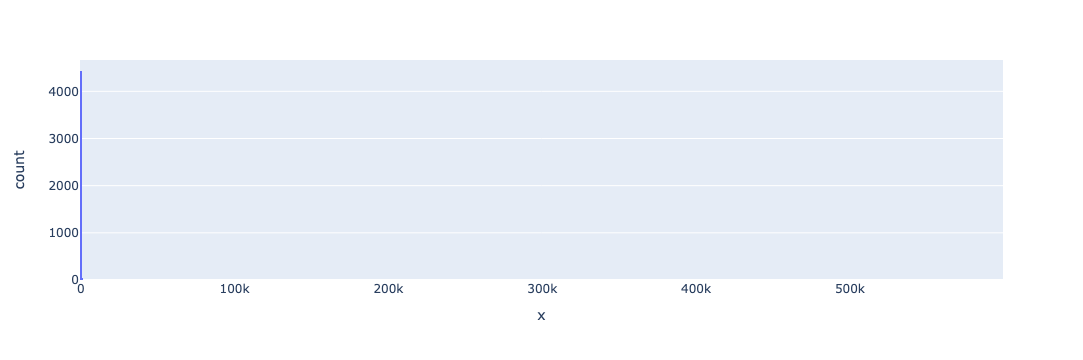

In [77]:
# check for outliers

# Create histogram
fig = px.histogram(x=straddles_df['Current Price'])

# Show plot
fig.show()

# remove outliers



<Axes: ylabel='Current Price'>

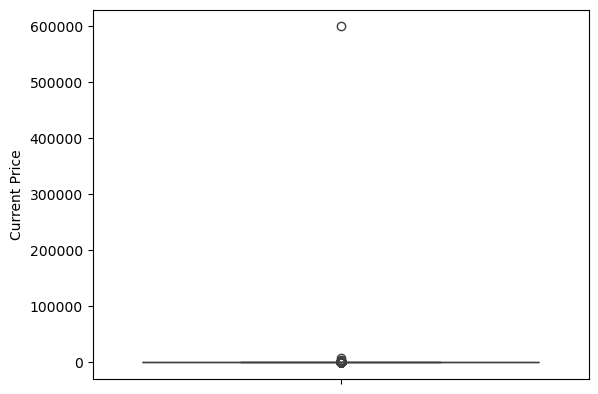

In [69]:
sns.boxplot(straddles_df['Current Price'])

In [91]:
straddles_df['MarketCap'].value_counts(dropna=False)
straddles_df.dtypes

Symbol                  object
Name                    object
Current Price          float64
% Change               float64
Avg Stock Volume         int64
Avg Option Volume      float64
Date                    object
Implied Move           float64
Actual Move            float64
Straddle Return        float64
Avg Straddle Return    float64
Max Return             float64
Min Return             float64
InWatchlist              int64
EtfHoldingsList         object
MarketCap              float64
dtype: object

In [88]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)).any(axis=1)]

# Remove outliers from the DataFrame
df_cleaned = remove_outliers_iqr(straddles_df)
df_cleaned

,Symbol,Name,Current Price,% Change,Avg Stock Volume,Avg Option Volume,Date,Implied Move,Actual Move,Straddle Return,Avg Straddle Return,Max Return,Min Return,InWatchlist,EtfHoldingsList,MarketCap
0,EDSA,Edesa Biotech - Common Shares,4.8300,0.0343,80026,NaN,2/9/2024,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1.531485e+07
3,CTLT,Catalent,56.7100,0.0028,2497920,2186.0,2/9/2024,0.0397,0.0028,-0.4520,0.1496,0.5174,-0.3961,0,SPY - XLV,1.024417e+10
6,TMQ,Trilogy Metals,0.4722,-0.0284,217769,25.0,2/9/2024,0.0955,-0.0274,NaN,NaN,NaN,NaN,0,NaN,7.360834e+07
9,EVI,Evi Industries,22.3000,0.0529,18312,NaN,2/9/2024,NaN,0.0529,NaN,NaN,NaN,NaN,0,IWM,3.115856e+08
12,TIXT,Telus Intl,9.4000,0.0251,239807,166.0,2/9/2024,0.0809,0.0251,-0.2705,-0.1276,-0.0512,-0.2177,0,NaN,2.569881e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4468,MMLP,Martin Midstream Partners LP - Common Units Re...,2.2200,0.0091,60442,34.0,10/18/2023,0.0365,-0.0173,-0.2716,-0.1954,0.2308,-0.5000,0,NaN,8.639087e+07
4470,SCL,Stepan Company,90.2400,0.0026,103199,31.0,10/18/2023,0.0570,0.0618,0.0536,0.5240,1.5555,-0.1427,0,IWM,2.012948e+09
4476,CCEL,Cryo-Cell International,5.6000,0.0000,10364,NaN,10/12/2023,NaN,0.0000,NaN,NaN,NaN,NaN,0,NaN,4.641512e+07
4479,NRIX,Nurix Therapeutics,8.8500,0.0267,688731,104.0,10/12/2023,0.0877,0.0225,-0.1347,0.1517,0.8077,-0.2377,0,IBB - IWM,4.292584e+08


In [154]:
#drop in watchlist column all values are "0"
df_cleaned['InWatchlist'].value_counts(dropna = False)

InWatchlist
0    2375
Name: count, dtype: int64

In [155]:
df_cleaned = df_cleaned.copy()
df_cleaned = df_cleaned.drop(columns = ['InWatchlist'])
df_cleaned

,Symbol,Name,Current Price,% Change,Avg Stock Volume,Avg Option Volume,Date,Implied Move,Actual Move,Straddle Return,Avg Straddle Return,Max Return,Min Return,EtfHoldingsList,MarketCap
0,EDSA,Edesa Biotech - Common Shares,4.8300,0.0343,80026,NaN,2/9/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.531485e+07
3,CTLT,Catalent,56.7100,0.0028,2497920,2186.0,2/9/2024,0.0397,0.0028,-0.4520,0.1496,0.5174,-0.3961,SPY - XLV,1.024417e+10
6,TMQ,Trilogy Metals,0.4722,-0.0284,217769,25.0,2/9/2024,0.0955,-0.0274,NaN,NaN,NaN,NaN,NaN,7.360834e+07
9,EVI,Evi Industries,22.3000,0.0529,18312,NaN,2/9/2024,NaN,0.0529,NaN,NaN,NaN,NaN,IWM,3.115856e+08
12,TIXT,Telus Intl,9.4000,0.0251,239807,166.0,2/9/2024,0.0809,0.0251,-0.2705,-0.1276,-0.0512,-0.2177,NaN,2.569881e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4468,MMLP,Martin Midstream Partners LP - Common Units Re...,2.2200,0.0091,60442,34.0,10/18/2023,0.0365,-0.0173,-0.2716,-0.1954,0.2308,-0.5000,NaN,8.639087e+07
4470,SCL,Stepan Company,90.2400,0.0026,103199,31.0,10/18/2023,0.0570,0.0618,0.0536,0.5240,1.5555,-0.1427,IWM,2.012948e+09
4476,CCEL,Cryo-Cell International,5.6000,0.0000,10364,NaN,10/12/2023,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,4.641512e+07
4479,NRIX,Nurix Therapeutics,8.8500,0.0267,688731,104.0,10/12/2023,0.0877,0.0225,-0.1347,0.1517,0.8077,-0.2377,IBB - IWM,4.292584e+08


In [164]:
# export cleaned straddles to csv 
df_cleaned.to_csv('straddle_data_cleaned.csv', index = False)


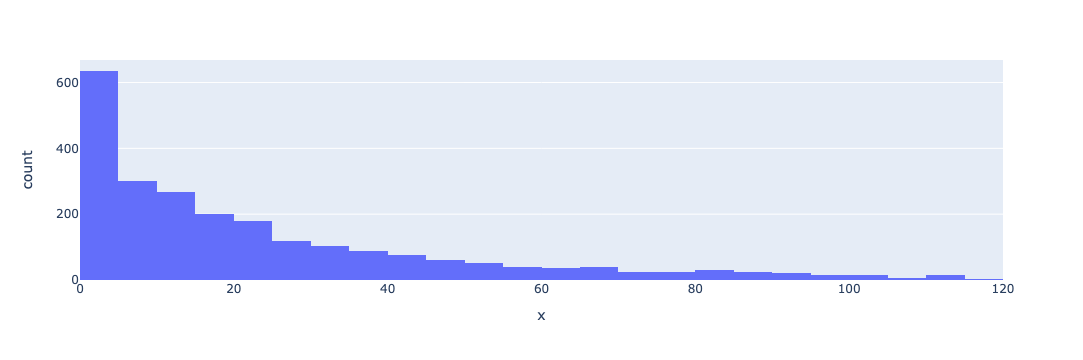

In [156]:
# Create histogram
fig = px.histogram(x=df_cleaned['Current Price'])

# Show plot
fig.show()

# remove outliers

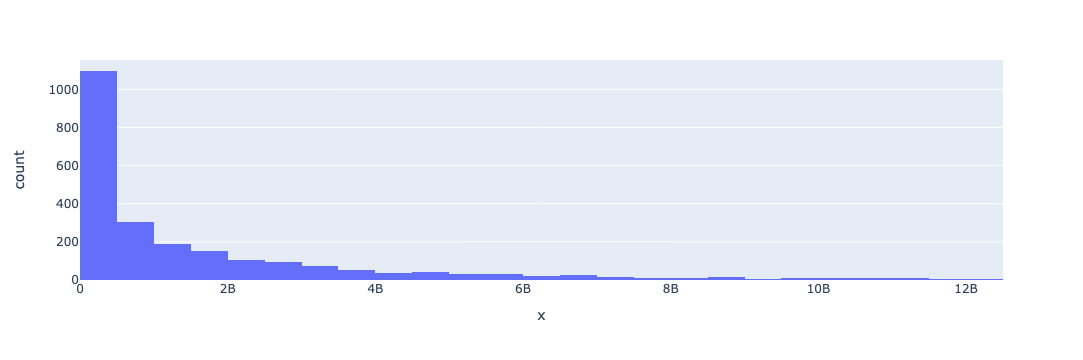

In [157]:
# Create histogram
fig = px.histogram(x=df_cleaned['MarketCap'])

# Show plot
fig.show()

### Get stock date to watch 

Find the next trading date based on earnings date release. 


Note:
AMEX stock exchange is also known as the NYSE American and follows the same open schedule as the NYSE, Will use the NYSE calendar for all AMEX values.

In [22]:
# dictionary of stock exchanges and codes 

stock_ex_codes = {
    'NYSE': 'XNYS',
    'New York Stock Exchange (NYSE)': 'XNYS',
    'NASDAQ': 'NASDAQ',
    'London Stock Exchange (LSE)': 'XLON',
    'Tokyo Stock Exchange (TSE)': 'XTKS',
    'Hong Kong Stock Exchange (HKEX)': 'XHKG',
    'Toronto Stock Exchange (TSX)': 'XTSE',
    'Shanghai Stock Exchange (SSE)': 'XSHG',
    'Shenzhen Stock Exchange (SZSE)': 'XSHE',
    'Bombay Stock Exchange (BSE)': 'XBOM',
    'National Stock Exchange of India (NSE)': 'XNSE',
    'AMEX': 'XNYS' # See note
}


In [25]:
# get the exchange code used to pull up market calendar: 
exchange_code = earnings_df['exchange'].map(stock_ex_codes)
exchange_code

0       NASDAQ
1       NASDAQ
2       NASDAQ
3       NASDAQ
4         XNYS
         ...  
9471    NASDAQ
9472      XNYS
9473    NASDAQ
9474      XNYS
9475      XNYS
Name: exchange, Length: 9393, dtype: object

In [26]:
# add exchange codes to dataframe - to be able to apply look up function
earnings_df.loc[:,'exchange_codes'] = exchange_code
earnings_df

,date,exchange,symbol,when,security_name,exchange_codes
0,2023-01-03,NASDAQ,LEDS,premarket,SemiLEDS Corporation - Common Stock,NASDAQ
1,2023-01-03,NASDAQ,SGH,postmarket,"SMART Global Holdings, Inc. - Ordinary Shares",NASDAQ
2,2023-01-04,NASDAQ,RGP,postmarket,"Resources Connection, Inc. - Common Stock",NASDAQ
3,2023-01-04,NASDAQ,SLP,postmarket,"Simulations Plus, Inc. - Common Stock",NASDAQ
4,2023-01-05,NYSE,CAG,NaN,"ConAgra Brands, Inc. Common Stock",XNYS
...,...,...,...,...,...,...
9471,2023-12-21,NASDAQ,LMNR,postmarket,Limoneira Co - Common Stock,NASDAQ
9472,2023-12-21,NYSE,NKE,NaN,"Nike, Inc. Common Stock",XNYS
9473,2023-12-21,NASDAQ,PAYX,premarket,"Paychex, Inc. - Common Stock",NASDAQ
9474,2023-12-21,NYSE,WS,postmarket,"Worthington Steel, Inc. Common Shares",XNYS


In [27]:
def get_next_trading_day(row):
    ''' Returns the next trading day that a specific exchange is open based on a input date, considering holidays / weekends.
    If no value for exchange return np.nan. 
    will be applied to a df.
    '''
    try:
        exchange =  mcal.get_calendar(row['exchange'])
        next_trading_day2 = exchange.valid_days(start_date=row['date'], end_date = row['date'] +pd.Timedelta(days=10))[1]
        return next_trading_day2
    except Exception as e:
        # print(f'Error:{e}')
        return np.nan

In [30]:
#show how long this cell took to run.
import timeit

start_time = timeit.default_timer()

earnings_df['next_trading_day'] = earnings_df.apply(get_next_trading_day, axis = 1)

elapsed = timeit.default_timer() - start_time
print(f"Time taken: {elapsed} seconds")

Time taken: 824.848221125 seconds


In [32]:
earnings_df

,date,exchange,symbol,when,security_name,exchange_codes,next_trading_day
0,2023-01-03,NASDAQ,LEDS,premarket,SemiLEDS Corporation - Common Stock,NASDAQ,2023-01-04 00:00:00+00:00
1,2023-01-03,NASDAQ,SGH,postmarket,"SMART Global Holdings, Inc. - Ordinary Shares",NASDAQ,2023-01-04 00:00:00+00:00
2,2023-01-04,NASDAQ,RGP,postmarket,"Resources Connection, Inc. - Common Stock",NASDAQ,2023-01-05 00:00:00+00:00
3,2023-01-04,NASDAQ,SLP,postmarket,"Simulations Plus, Inc. - Common Stock",NASDAQ,2023-01-05 00:00:00+00:00
4,2023-01-05,NYSE,CAG,NaN,"ConAgra Brands, Inc. Common Stock",XNYS,2023-01-06 00:00:00+00:00
...,...,...,...,...,...,...,...
9471,2023-12-21,NASDAQ,LMNR,postmarket,Limoneira Co - Common Stock,NASDAQ,2023-12-22 00:00:00+00:00
9472,2023-12-21,NYSE,NKE,NaN,"Nike, Inc. Common Stock",XNYS,2023-12-22 00:00:00+00:00
9473,2023-12-21,NASDAQ,PAYX,premarket,"Paychex, Inc. - Common Stock",NASDAQ,2023-12-22 00:00:00+00:00
9474,2023-12-21,NYSE,WS,postmarket,"Worthington Steel, Inc. Common Shares",XNYS,2023-12-22 00:00:00+00:00


In [36]:
# keep only date for next trading day column and date column
# earnings_df.loc[:,'next_trading_day'] = pd.to_datetime(earnings_df['next_trading_day']).dt.date
# earnings_df.loc[:,'date'] = pd.to_datetime(earnings_df['date']).dt.date


In [37]:
earnings_df

,date,exchange,symbol,when,security_name,exchange_codes,next_trading_day
0,2023-01-03,NASDAQ,LEDS,premarket,SemiLEDS Corporation - Common Stock,NASDAQ,2023-01-04
1,2023-01-03,NASDAQ,SGH,postmarket,"SMART Global Holdings, Inc. - Ordinary Shares",NASDAQ,2023-01-04
2,2023-01-04,NASDAQ,RGP,postmarket,"Resources Connection, Inc. - Common Stock",NASDAQ,2023-01-05
3,2023-01-04,NASDAQ,SLP,postmarket,"Simulations Plus, Inc. - Common Stock",NASDAQ,2023-01-05
4,2023-01-05,NYSE,CAG,NaN,"ConAgra Brands, Inc. Common Stock",XNYS,2023-01-06
...,...,...,...,...,...,...,...
9471,2023-12-21,NASDAQ,LMNR,postmarket,Limoneira Co - Common Stock,NASDAQ,2023-12-22
9472,2023-12-21,NYSE,NKE,NaN,"Nike, Inc. Common Stock",XNYS,2023-12-22
9473,2023-12-21,NASDAQ,PAYX,premarket,"Paychex, Inc. - Common Stock",NASDAQ,2023-12-22
9474,2023-12-21,NYSE,WS,postmarket,"Worthington Steel, Inc. Common Shares",XNYS,2023-12-22


In [40]:
# store as datetime types
earnings_df['next_trading_day'] = pd.to_datetime(earnings_df['next_trading_day'])
earnings_df['date'] = pd.to_datetime(earnings_df['date'])
earnings_df.dtypes

date                datetime64[ns]
exchange                    object
symbol                      object
when                        object
security_name               object
exchange_codes              object
next_trading_day    datetime64[ns]
dtype: object

### Next trading day or day of 

In [42]:
earnings_df['when'].value_counts(dropna=False)

when
postmarket    4100
NaN           2977
premarket     2316
Name: count, dtype: int64

In [44]:
## ASSUMPTION - IF NO specification on when, assuming pre market and using same day as release as the eps day (per direction from manager)

def eps_day(row):
    eps_day_value = np.nan
    if row['when'] == 'premarket':
        eps_day_value = row['date']
    elif row['when'] == 'postmarket':
         eps_day_value = row['next_trading_day']
    elif pd.isna(row['when']):
        eps_day_value = row['date']
    return eps_day_value

In [45]:
## Based on when the EPS is announced, determine the day we are interested in for movement
earnings_df['eps_day'] = earnings_df.apply(eps_day, axis = 1)

In [46]:
earnings_df

,date,exchange,symbol,when,security_name,exchange_codes,next_trading_day,eps_day
0,2023-01-03,NASDAQ,LEDS,premarket,SemiLEDS Corporation - Common Stock,NASDAQ,2023-01-04,2023-01-03
1,2023-01-03,NASDAQ,SGH,postmarket,"SMART Global Holdings, Inc. - Ordinary Shares",NASDAQ,2023-01-04,2023-01-04
2,2023-01-04,NASDAQ,RGP,postmarket,"Resources Connection, Inc. - Common Stock",NASDAQ,2023-01-05,2023-01-05
3,2023-01-04,NASDAQ,SLP,postmarket,"Simulations Plus, Inc. - Common Stock",NASDAQ,2023-01-05,2023-01-05
4,2023-01-05,NYSE,CAG,NaN,"ConAgra Brands, Inc. Common Stock",XNYS,2023-01-06,2023-01-05
...,...,...,...,...,...,...,...,...
9471,2023-12-21,NASDAQ,LMNR,postmarket,Limoneira Co - Common Stock,NASDAQ,2023-12-22,2023-12-22
9472,2023-12-21,NYSE,NKE,NaN,"Nike, Inc. Common Stock",XNYS,2023-12-22,2023-12-21
9473,2023-12-21,NASDAQ,PAYX,premarket,"Paychex, Inc. - Common Stock",NASDAQ,2023-12-22,2023-12-21
9474,2023-12-21,NYSE,WS,postmarket,"Worthington Steel, Inc. Common Shares",XNYS,2023-12-22,2023-12-22


In [47]:
earnings_df.dtypes

date                datetime64[ns]
exchange                    object
symbol                      object
when                        object
security_name               object
exchange_codes              object
next_trading_day    datetime64[ns]
eps_day             datetime64[ns]
dtype: object

In [48]:
## export df to csv
earnings_df.to_csv("/users/brigitteasullivan/Documents/0. Data Science/Notebooks/Riipen Project/eps-stock-market-ml-project/data/next_trading_days.csv", index=False)


## Filter Trading Dates for tickers

Based on tickers in ticker csv, only keep earnings dates records for those stocks

In [49]:
earnings_df_filter = earnings_df[earnings_df['symbol'].isin(tickers_df['Ticker'])].copy()
earnings_df_filter

,date,exchange,symbol,when,security_name,exchange_codes,next_trading_day,eps_day
0,2023-01-03,NASDAQ,LEDS,premarket,SemiLEDS Corporation - Common Stock,NASDAQ,2023-01-04,2023-01-03
1,2023-01-03,NASDAQ,SGH,postmarket,"SMART Global Holdings, Inc. - Ordinary Shares",NASDAQ,2023-01-04,2023-01-04
2,2023-01-04,NASDAQ,RGP,postmarket,"Resources Connection, Inc. - Common Stock",NASDAQ,2023-01-05,2023-01-05
3,2023-01-04,NASDAQ,SLP,postmarket,"Simulations Plus, Inc. - Common Stock",NASDAQ,2023-01-05,2023-01-05
4,2023-01-05,NYSE,CAG,NaN,"ConAgra Brands, Inc. Common Stock",XNYS,2023-01-06,2023-01-05
...,...,...,...,...,...,...,...,...
9470,2023-12-21,NYSE,KMX,premarket,CarMax Inc,XNYS,2023-12-22,2023-12-21
9471,2023-12-21,NASDAQ,LMNR,postmarket,Limoneira Co - Common Stock,NASDAQ,2023-12-22,2023-12-22
9472,2023-12-21,NYSE,NKE,NaN,"Nike, Inc. Common Stock",XNYS,2023-12-22,2023-12-21
9473,2023-12-21,NASDAQ,PAYX,premarket,"Paychex, Inc. - Common Stock",NASDAQ,2023-12-22,2023-12-21


In [50]:
ticker_unique_num = tickers_df['Ticker'].nunique()
print('unique ticker symbols in ticker df:', ticker_unique_num)

symbol_unique_num = earnings_df['symbol'].nunique()
print('unique symbols in earnings df:', symbol_unique_num)


# in both ticker and earnings df
combined_df = pd.concat([earnings_df['symbol'], tickers_df['Ticker']])
unique_ticker = set(tickers_df['Ticker'].unique())
unique_earnings = set(earnings_df['symbol'].unique())

intersection = list(unique_ticker.intersection(unique_earnings))
length_intersection = len(intersection)
print('unique symbols in earnings df AND in ticker:', length_intersection)

unique ticker symbols in ticker df: 12834
unique symbols in earnings df: 2725
unique symbols in earnings df AND in ticker: 2501


In [52]:
#export to CSV
earnings_df_filter.to_csv('/users/brigitteasullivan/Documents/0. Data Science/Notebooks/Riipen Project/eps-stock-market-ml-project/data/eps_days.csv', index = False)


### BIN

In [ ]:
earnings_df['next_trading_day'] = 

In [ ]:
date_check = earnings_df['date'][10]
stock_check = earnings_df['exchange'][10]
print(date_check)a
print(stock_check

In [ ]:
# next_trading_day = nyse_exchange.valid_days(start_date=date_check, end_date=(date_check + pd.Timedelta(days=10)))[1]
# print('next trading day test: ', next_trading_day)

function_test = get_next_trading_day(date_check, stock_check)
print('function test', function_test)

In [ ]:
    if stock_exchange == "NASDAQ":
        # laksdj
        next_trading_day1 = nasdaq_exchange.valid_days(start_date=date, end_date=date + pd.Timedelta(days=10))[1]
    elif stock_exchange == "NYSE":
        next_trading_day1 = nyse_exchange.valid_days(start_date=date, end_date=date + pd.Timedelta(days=10))[1]
    return next_trading_day1

In [ ]:
earnings_df.head(11)

### Earnings data

In [54]:
df = pd.read_csv('EarningsStraddles_RecentEarnings_Results_20240211_210820 copy.csv')



In [55]:
# % change from close value day prior.  
# Date format = MM/DD/YYYY
# date of earnings release
# Current Price : PRICE of stock on Date

# IMPORTANT:  STOCK VOL and AVG OPTION VOLUME, Symbol	Name	Current Price	% Change	Avg Stock Volume	Avg Option Volume	Date

## NEED Volatility (max / min) for 1 year

In [57]:
# df['Date'

In [58]:
df['Name'].value_counts()

Name
Liberty Siriusxm Gr                                                                   3
Liberty Formula One Group                                                             2
Edesa Biotech - Common Shares                                                         1
Evotec Se - American Depositary Shares Each Representing 1/2 Of One Ordinary Share    1
Taboola.com Ltd. -                                                                    1
                                                                                     ..
Carbon Revolution Public Limited Company -                                            1
Champions Oncology                                                                    1
System1 Class A                                                                       1
Frequency Electronics                                                                 1
Art's-Way Manufacturing Co.                                                           1
Name: count, Length: 4482, 

In [60]:
df

,Symbol,Name,Current Price,% Change,Avg Stock Volume,Avg Option Volume,Date,Implied Move,Actual Move,Straddle Return,Avg Straddle Return,Max Return,Min Return,InWatchlist,EtfHoldingsList,MarketCap
0,EDSA,Edesa Biotech - Common Shares,4.83,0.0343,80026,NaN,2/9/2024,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1.531485e+07
1,ASYS,Amtech Systems,3.44,-0.1527,93839,143.0,2/9/2024,0.1210,0.0523,NaN,0.7910,0.9241,0.7153,0,NaN,4.881697e+07
2,FTS,Fortis Common Shares,39.06,0.0031,797151,150.0,2/9/2024,0.0347,0.0031,-0.0459,0.1247,0.8084,-0.4825,0,NaN,1.908081e+10
3,CTLT,Catalent,56.71,0.0028,2497920,2186.0,2/9/2024,0.0397,0.0028,-0.4520,0.1496,0.5174,-0.3961,0,SPY - XLV,1.024417e+10
4,NWL,Newell Brands,6.85,-0.1893,4255129,1956.0,2/9/2024,0.0976,-0.1893,0.9235,-0.1984,-0.0296,-0.4570,0,NaN,2.837270e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4480,BYRN,Byrna Technologies,9.84,0.1069,85590,60.0,10/12/2023,0.1409,0.0221,-0.0941,1.5457,2.7886,-0.6517,0,NaN,2.165000e+08
4481,DPZ,Domino's Pizza,425.09,-0.0035,585561,2915.0,10/12/2023,0.0558,-0.0110,-0.6825,0.1485,0.6398,-0.5731,0,SPY - XLY,1.482756e+10
4482,RMCF,Rocky Mountain Chocolate Factory,4.05,0.0050,16550,NaN,10/12/2023,NaN,-0.0545,NaN,NaN,NaN,NaN,0,NaN,2.557680e+07
4483,DOGZ,Dogness (Intl),3.53,0.0665,93563,11.0,10/11/2023,0.1009,0.0111,NaN,0.3535,1.0157,-0.0596,0,NaN,7.370058e+06
